In [1]:
import pandas as pd, os

bucket = os.environ["PROJECT_BUCKET"]       # 已 setx 过
train_s3 = f"s3://{bucket}/processed/train.csv"
val_s3   = f"s3://{bucket}/processed/val.csv"
test_s3  = f"s3://{bucket}/processed/test.csv"

train = pd.read_csv(train_s3)   # 若本地也有可直接 ../data/train.csv
val   = pd.read_csv(val_s3)
test  = pd.read_csv(test_s3)

print(train.shape, val.shape, test.shape)
train.head()

(46763, 2) (10021, 2) (10021, 2)


,text,label
0,wells fargo bill atty services xxxx xxxx xxxx ...,5
1,account usaa called xxxx xxxx xxxx data breach...,0
2,xxxx xxxx unauthorized charges made xxxx xxxx ...,3
3,bank american owed 8000 00 funds said owed tim...,5
4,urgent sheriff sale xxxx xxxx 2015hi wells far...,5


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
import time, joblib, pathlib

start = time.time()

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=40_000,
        ngram_range=(1,2),
        stop_words='english')),
    ('clf', LogisticRegression(
        max_iter=500,
        class_weight='balanced',   # 处理类别不平衡
        n_jobs=-1))
])

pipeline.fit(train['text'], train['label'])
print(f"✅ 训练完成，用时 {time.time()-start:.1f}s")

✅ 训练完成，用时 17.2s


In [3]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ====== 验证集（可选快速调参） ======
val_pred = pipeline.predict(val['text'])
val_f1 = f1_score(val['label'], val_pred, average='macro')
print("Val Macro-F1:", round(val_f1, 4))

# ====== 测试集最终报告 ======
test_pred = pipeline.predict(test['text'])
print(classification_report(test['label'], test_pred, digits=3))

macro_f1 = f1_score(test['label'], test_pred, average='macro')
print("Test Macro-F1:", round(macro_f1, 4))

Val Macro-F1: 0.7948
              precision    recall  f1-score   support

           0      0.796     0.791     0.793       856
           1      0.666     0.739     0.701       551
           2      0.803     0.814     0.809      1190
           3      0.849     0.852     0.850      1879
           4      0.869     0.819     0.843      2633
           5      0.948     0.917     0.933      2238
           6      0.482     0.699     0.570       226
           7      0.732     0.868     0.794       129
           8      0.868     0.925     0.895       319

    accuracy                          0.841     10021
   macro avg      0.779     0.825     0.799     10021
weighted avg      0.847     0.841     0.843     10021

Test Macro-F1: 0.7987


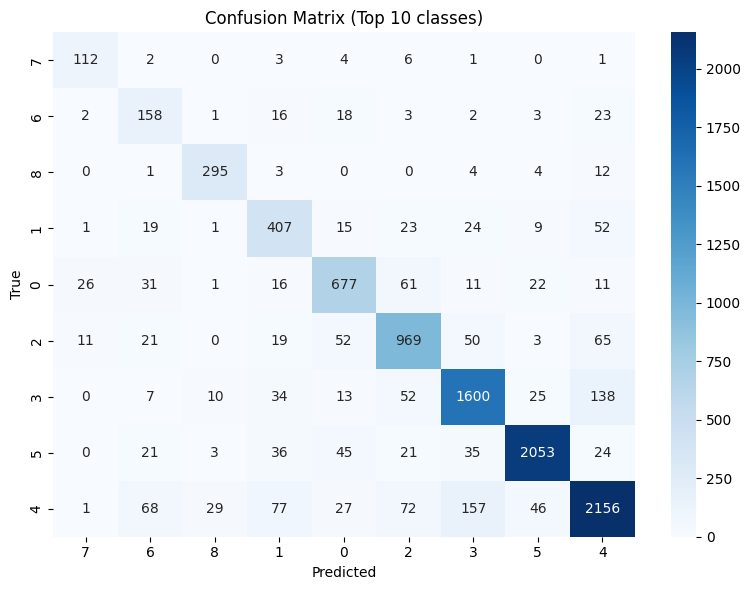

In [4]:
# 取样本数最多的 10 个类别索引
top_classes = np.argsort(
        np.bincount(test['label']))[-10:]  # 最后 10 个是计数最多

cm = confusion_matrix(test['label'], test_pred, labels=top_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=top_classes, yticklabels=top_classes,
            cmap='Blues')
plt.title("Confusion Matrix (Top 10 classes)")
plt.ylabel("True"); plt.xlabel("Predicted")
plt.tight_layout(); plt.show()

In [5]:
import joblib, pathlib, datetime as dt, json

art_dir = pathlib.Path("../artifacts/baseline")   # 视 notebook 位置调整相对路径
art_dir.mkdir(parents=True, exist_ok=True)

# ① 读取映射文件
label2product = joblib.load(art_dir / "label_mapping.pkl")

# ② 保存模型+映射
joblib.dump(
    {"model": pipeline, "label2product": label2product},
    art_dir / "tfidf_logreg.pkl"
)

# ③ 保存评估摘要
eval_info = {
    "timestamp": dt.datetime.utcnow().isoformat()+"Z",
    "test_macro_f1": float(macro_f1)
}
json.dump(eval_info, open(art_dir / "eval_report.json", "w"), indent=2)

print("✅ 模型与评估文件保存完毕：", list(art_dir.iterdir()))


✅ 模型与评估文件保存完毕： [WindowsPath('../artifacts/baseline/eval_report.json'), WindowsPath('../artifacts/baseline/label_mapping.json'), WindowsPath('../artifacts/baseline/label_mapping.pkl'), WindowsPath('../artifacts/baseline/tfidf_logreg.pkl')]
